### Introduction

In this Notebook, we will be creating a model of models. That is, a model that evaluates the outputs of other models, trains on their outputs against the targets and then gives out an output itself. We will be evaluation various models, parameters and techniques in order to hopefully achieve a model that performs better than its individual constituents.

####  Data

First we need to get the data which in this case is a table with the outputs of the other models.
We also need to choose which securities we will be training the model on.
- This raises an interesting question to whether models perform best when trained on and applied to a single security or if its better to train the model on many securities to have a larger amount of data.

In [26]:
from trading_models import combine_model_outputs
import pandas as pd

# List of securities
securities = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'TSLA']  # Add more securities as needed

# Threshold for fees
threshold = 0.01

def combine_multiple_securities(securities, start_date, end_date):
    combined_df = pd.DataFrame()

    for symbol in securities:
        data = combine_model_outputs(symbol, start_date, end_date, fees = threshold)
        data['Symbol'] = symbol  # Add a column to identify the security
        combined_df = pd.concat([combined_df, data])

    return combined_df

# Combine data for multiple securities
model_of_models_data = combine_multiple_securities(securities, '2013-01-01', '2023-12-31')

print(model_of_models_data)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

                 Close     Volume    Short_MA     Long_MA  MA_Signal  \
Date                                                                   
2013-01-02   19.608213  560518000   19.608213   19.608213          0   
2013-01-03   19.360714  352965200   19.484464   19.484464          0   
2013-01-04   18.821428  594333600   19.263452   19.263452          0   
2013-01-07   18.710714  484156400   19.125268   19.125268          0   
2013-01-08   18.761070  458707200   19.052428   19.052428          0   
...                ...        ...         ...         ...        ...   
2023-12-22  252.539993   93249800  233.655000  241.505100          0   
2023-12-26  256.609985   86892400  234.887749  241.477999          0   
2023-12-27  261.440002  106494400  236.489750  241.553799          0   
2023-12-28  253.179993  113619900  237.798249  241.571099          0   
2023-12-29  248.479996  100615300  238.868749  241.558899          0   

            BB_Signal  RSI_Signal  SMA_Signal  RF_Prediction  F

In [27]:
# Remove nan values
model_of_models_data = model_of_models_data.dropna()

In [28]:
# Check the distribution of the target variable
# This is an important step because as we change the percentage change threshold, the distribution of the target variable will change

target_distribution = model_of_models_data['Target'].value_counts()
print(target_distribution)

Target
 0.0    6962
 1.0    3798
-1.0    3075
Name: count, dtype: int64


In [29]:
# Split the data into target and features
X = model_of_models_data.drop(columns=['Future_Return', 'Target', 'Symbol'])
y = model_of_models_data['Target']

In [30]:
# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Train and evaluate multiple models at a time

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier(random_state=42, max_iter=1000)
}

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        results[name] = {'model': model, 'accuracy': accuracy, 'report': report}
        print(f'{name} Accuracy: {accuracy:.2f}')
        print(classification_report(y_test, y_pred))
    return results

In [22]:
results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

RandomForest Accuracy: 0.51
              precision    recall  f1-score   support

        -1.0       0.36      0.23      0.28       613
         0.0       0.57      0.75      0.65      1378
         1.0       0.40      0.28      0.33       776

    accuracy                           0.51      2767
   macro avg       0.44      0.42      0.42      2767
weighted avg       0.48      0.51      0.48      2767

GradientBoosting Accuracy: 0.57
              precision    recall  f1-score   support

        -1.0       0.56      0.15      0.23       613
         0.0       0.57      0.93      0.71      1378
         1.0       0.56      0.27      0.36       776

    accuracy                           0.57      2767
   macro avg       0.56      0.45      0.43      2767
weighted avg       0.56      0.57      0.50      2767

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

/Users/martinperret/Desktop/THE JOURNEY/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/martinperret/Desktop/THE JOURNEY/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/martinperret/Desktop/THE JOURNEY/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

SVM Accuracy: 0.50
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       613
         0.0       0.50      1.00      0.67      1378
         1.0       0.00      0.00      0.00       776

    accuracy                           0.50      2767
   macro avg       0.17      0.33      0.22      2767
weighted avg       0.25      0.50      0.33      2767

KNN Accuracy: 0.42
              precision    recall  f1-score   support

        -1.0       0.24      0.26      0.25       613
         0.0       0.52      0.66      0.58      1378
         1.0       0.31      0.14      0.19       776

    accuracy                           0.42      2767
   macro avg       0.35      0.35      0.34      2767
weighted avg       0.40      0.42      0.40      2767

MLP Accuracy: 0.50
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       613
         0.0       0.50      1.00      0.66      1378
         1.0      

/Users/martinperret/Desktop/THE JOURNEY/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/martinperret/Desktop/THE JOURNEY/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/martinperret/Desktop/THE JOURNEY/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

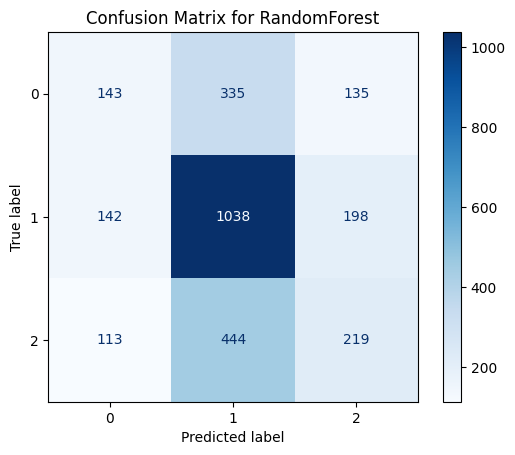

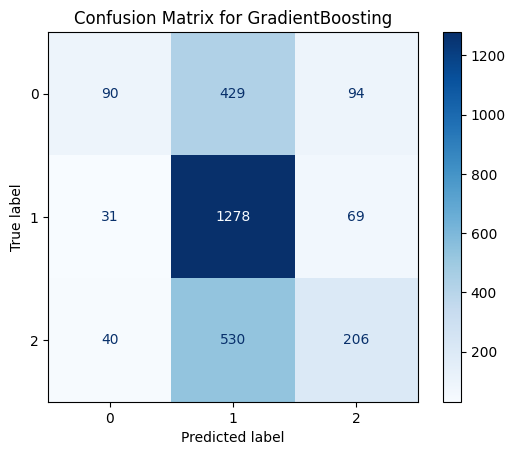

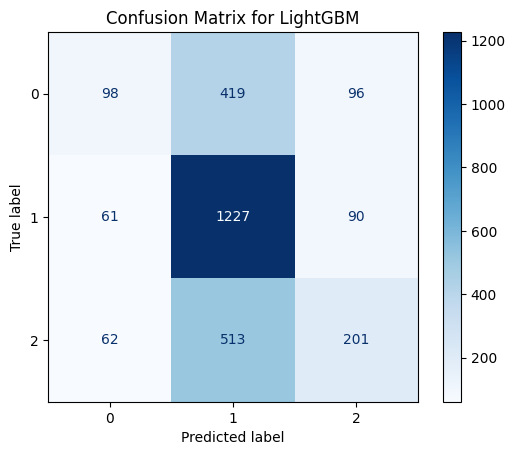

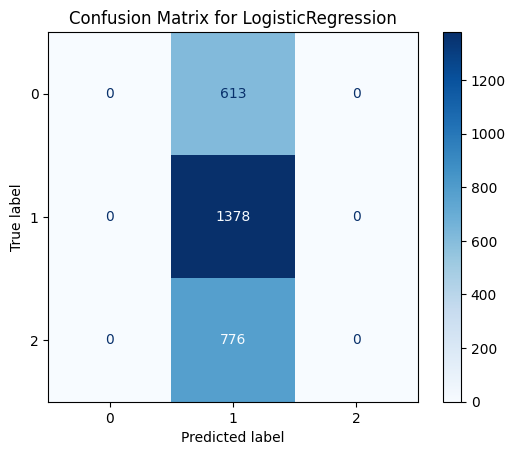

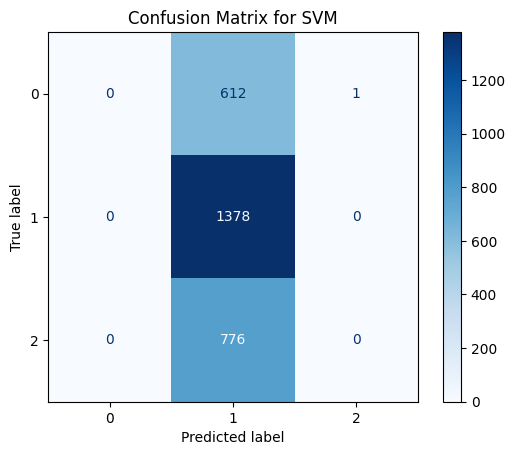

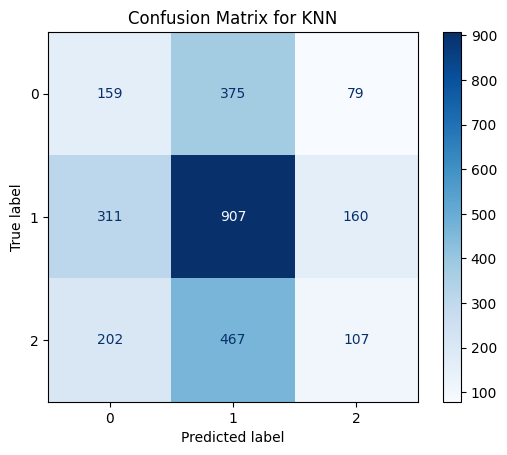

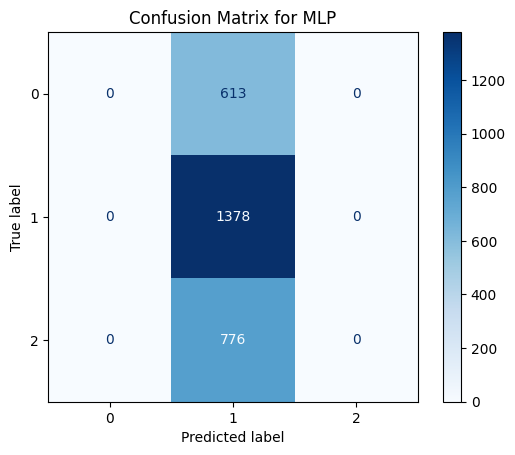

In [23]:
# Plotting the confusion matrices

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Function to plot confusion matrix
def plot_confusion_matrix(model_name, y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Plot confusion matrices for all models
for name, result in results.items():
    plot_confusion_matrix(name, y_test, result['model'].predict(X_test))

Now we need to decide which model we are going to use:


We can see that
- Logistic Regression
- MLP
- SVM

are not working for our data and business case.

We now try to use Random Forest and Gradient Boosting and improve their metrics using hyperparameter tuning.

In [24]:
# Random Forest with hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define a parameter grid
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True]
}

# Create a base model
rf = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid_rf,
                           cv=3, n_jobs=-1, verbose=0, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Extract the best model from the grid search
model_rf = grid_search.best_estimator_
model_rf.fit(X_train, y_train)

# Quick evaluation of the model
y_pred = model_rf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')

Accuracy: 0.57


In [25]:
# Now we do the same thing but for Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier

# Define a  parameter grid
param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

# Create a base model
gb = GradientBoostingClassifier(random_state=42)

# Instantiate the grid search model
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb,
                              cv=3, n_jobs=-1, verbose=0, scoring='accuracy')

# Fit the grid search to the data
grid_search_gb.fit(X_train, y_train)

# Extract the best model from the grid search
model_gb = grid_search_gb.best_estimator_
model_gb.fit(X_train, y_train)

# Quick evaluation of the model
y_pred_gb = model_gb.predict(X_test)
print(f'Gradient Boosting Accuracy: {accuracy_score(y_test, y_pred_gb):.2f}')

Gradient Boosting Accuracy: 0.58


We can see that both of these models achieve an accuracy of around 58%.
This accuracy may be a little misleading in either direction, however, given that these models are predicting 'hold' more often than not due to an imbalance in the data set. It is still possible that the strategy is profitable. We will evaluate the final metrics for all the  models as well as profitability in the Capstone_evaluation file.

In [31]:
# Save GradientBoosting to use in the Dashboard and in trading bot

import joblib

joblib.dump(model_gb, 'trained_model.pkl')

['trained_model.pkl']